# Analysis 

In [214]:
import pandas as pd
import numpy as np

In [215]:
restaurant_df=pd.read_csv('restaurants1.csv')
review_df=pd.read_csv('reviews_fin.csv', sep=';')

In [216]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a..."
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you..."
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom..."
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...


### Sentiment analysis des avis en moyenne

In [217]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [218]:
# Initialisation de VADER
analyzer = SentimentIntensityAnalyzer()

# Fonction pour obtenir le sentiment
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Application de la fonction à chaque avis
review_df['sentiment'] = review_df['translated_text'].apply(get_sentiment)

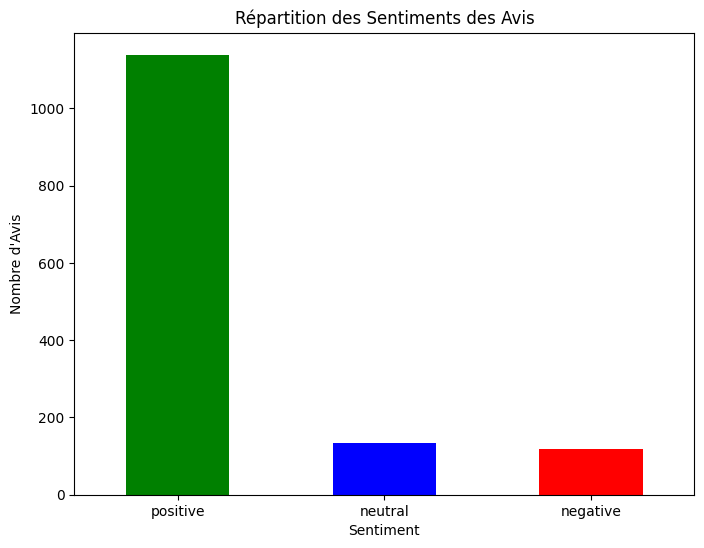

In [219]:
# Compter les sentiments
sentiment_counts = review_df['sentiment'].value_counts()

# Création d'un diagramme à barres
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Répartition des Sentiments des Avis')
plt.xlabel('Sentiment')
plt.ylabel('Nombre d\'Avis')
plt.xticks(rotation=0)
plt.show()

In [220]:
# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

# Créer une pipeline d'analyse de sentiment
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def analyze_sentiment(text):
    # Effectuer l'analyse de sentiment
    result = sentiment_analysis(text)

    # Récupérer le label (POSITIF ou NEGATIF) et le transformer en positif/négatif/neutre
    label = result[0]['label']
    return label

# Appliquer l'analyse de sentiment à chaque avis
review_df['sentiment'] = review_df['translated_text'].apply(analyze_sentiment)

# Afficher les résultats
print(review_df[['translated_text', 'sentiment']].head())

KeyboardInterrupt: 

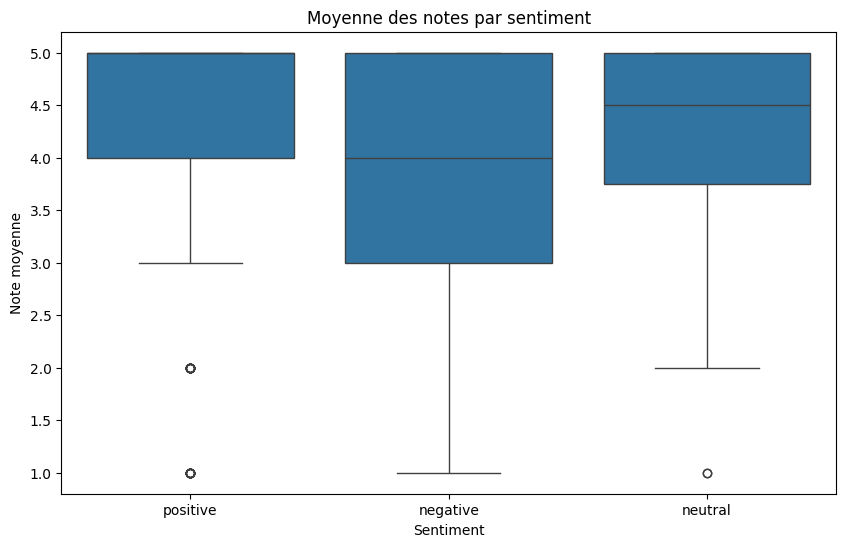

In [14]:
# Création d'un graphique pour visualiser les notes par rapport aux sentiments
plt.figure(figsize=(10, 6))

# Utiliser Seaborn pour créer un diagramme en barres
sns.boxplot(x='sentiment', y='rating', data=review_df)

# Personnaliser le graphique
plt.title('Moyenne des notes par sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Note moyenne')

# Afficher le graphique
plt.show()

### Preprocessing

In [48]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk import pos_tag
import re

In [47]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Remplacer les contractions courantes
    contractions = {
        "n't": " not",
        "'ve": "",
        "'s": "",
        "'m": " am",
        "'ll": " will",
        "'d": " would",
        "'re": " are",
        "'t": " not"
    }
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text.lower())

    # Supprimer les caractères non alphanumériques, sauf les apostrophes
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Filtrage des stopwords et gestion des négations
    processed_tokens = []
    negation = False
    for i, token in enumerate(tokens):
        if token in stop_words and token not in ['not', 'no']:
            continue
        if negation:
            processed_tokens.append(f"not_{token}")
            negation = False
        elif token in ['not', 'no']:
            negation = True
        else:
            processed_tokens.append(token)
    
    # Création des bigrams pertinents
    bigrams = ["_".join(gram) for gram in ngrams(processed_tokens, 2) if not any(word in gram for word in stop_words)]
    
    # Concaténation des tokens et des bigrams
    return " ".join(processed_tokens + bigrams)

# Appliquer le prétraitement sur le DataFrame
review_df['preprocessed_text'] = review_df['corrected_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rosel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rosel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [221]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  # Change to 'french' for French stopwords

# Ajouter des mots non informatifs spécifiques à la liste des stopwords
additional_non_informative_words = {'one', 'us', 'want', 'come', 'go', 'get', 'make', 'even', 'would', 'could', 'le','de','like','get','restaurant','paris','also','ever'}
stop_words = stop_words.union(additional_non_informative_words)

# Fonction pour convertir la tag POS de nltk en tag utilisable par le lemmatizer
def nltk_pos_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def preprocess_text(text):
    
    contractions = {
        "n't": " not",
        "'ve": "",
        "'s": "",
        "'m": " am",
        "'ll": " will",
        "'d": " would",
        "'re": " are",
        "'t": " not"
    }
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text.lower())
    
    # Suppression des caractères non alphanumériques et mise en minuscules
    text = re.sub(r"[^\w\s]", "", text.lower())
    
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Filtrage des stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Obtention des tags POS
    nltk_pos_tags = pos_tag(tokens)
    
    # Lemmatisation
    lemmas = []
    for word, nltk_pos in nltk_pos_tags:
        wordnet_pos = nltk_pos_to_wordnet_pos(nltk_pos)
        if wordnet_pos is None:
            lemma = word  # Si aucun tag POS correspondant, le mot est laissé tel quel
        else:
            lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmas.append(lemma)
    
    # Filtrage des stopwords standard et des mots non informatifs supplémentaires
    filtered_lemmas = [lemma for lemma in lemmas if lemma not in stop_words and lemma not in additional_non_informative_words]
    

    # Création des bigrams
    bigrams_list = list(ngrams(lemmas, 2))
    # Fusion des mots dans les bigrams avec un underscore pour une meilleure lisibilité
    bigrams = ['_'.join(gram) for gram in bigrams_list]

    # Création des bigrams
    trigrams_list = list(ngrams(lemmas, 3))
    # Fusion des mots dans les bigrams avec un underscore pour une meilleure lisibilité
    trigrams = ['_'.join(gram) for gram in trigrams_list]
    
    # Concaténation des tokens et des bigrams
    return " ".join(filtered_lemmas + bigrams + trigrams)

# Imaginons que review_df['corrected_text'] contienne vos avis corrigés
# Appliquer la fonction de prétraitement sur chaque avis
review_df['preprocessed_text'] = review_df['corrected_text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positive,base menu present write glow review classiques...
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positive,place feel little bit tourist trap people din ...
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positive,love french onion soup try comptoir la gastron...
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",positive,daughter son law mom gratin delicious table ex...
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positive,tiny eatery along seine leave bank best burger...


In [90]:
review_df[(review_df['rating'] == 1) | (review_df['rating'] == 2)].head(10)

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
27,cSw70yMlnM0eeYo2b-WRGA,7PdebIxh9qp4oKYE4aWGdA,"Service was excellent, drinks were okay, and t...",2,2023-08-21 07:56:11,027UxK4FQCRXalz-HoKWow,"Service was excellent, drinks were okay, and f...","Service was excellent, drinks were okay, and t...",positive,service excellent drink okay food barely mid a...
34,WHHt_Jb8Tgidn9mW7oDnIg,P2WEJlhrMCqdUbDEY5vLmQ,It closed three years ago. We walked all over...,1,2023-06-27 21:23:05,9cPSIY7fvmVdcqcet1tixg,It closed three years ago. We walked all over ...,It closed three years ago. We walked all over...,negative,close three year ago walk look told close anot...
35,WHHt_Jb8Tgidn9mW7oDnIg,5vj46mglCUT8_jVFgO8L7g,Doesn't exist at the address listed I double a...,1,2022-07-22 12:23:01,NguGOkT5QDUwk_qkBQ0j_Q,Doesn't exist at the address listed I double c...,Doesn't exist at the address listed I double a...,negative,exist address list double checked google map a...
37,ijqSzadlZ9SCXvUEpMimcA,lBDf2KXJtrFLWq0LQ9gxCA,As im standing outside in this cold weather im...,1,2023-12-27 22:51:52,xnMexMFn8WBsx2B2LLjyXg,"As I am standing outside in this cold weather,...",As im standing outside in this cold weather im...,negative,stand outside cold weather kinda frustrate wak...
49,u0PQ2A4w14iMWrrk5pWGUA,j7UIOeMdrlJ76jjlwpxa5g,RACIST and unrespectful.\n\nI ordered a 3 cour...,1,2023-11-07 10:49:00,cuc7MgP1lEM6LgMbX5KzHw,I ordered a 3 course diner wine coffee that co...,RACIST and unrespectful.\n\nI ordered a 3 cour...,negative,order 3 course diner wine coffee cost 65 euro ...
59,e6RHSG0d94yzA3McN-eFxg,wNCnYnOsQhRNt0QBIMeXBA,Could not find it with directions provided. Do...,1,2023-10-01 13:38:18,Ave6QKhnZlZMPIi3P6Nu1w,Could not find it with directions provided. Do...,Could not find it with directions provided. Do...,neutral,find direction provide still exist stay close ...
64,lTGYl3EcDKgXUhKpd7qQsw,L0YbpomUVmsmZDasgntUag,I was served a singularly mediocre Croque Mada...,2,2024-01-09 08:35:21,cmjhtZOE5Ni5bwZKH3skFQ,I was served a singularly mediocre Croque Mada...,I was served a singularly mediocre Croque Mada...,positive,serve singularly mediocre croque madame far we...
76,sFdV05m6Pw5Rw6DdrpQlIw,EZzLbtwOWjSpCkW2f6ec5g,This was literally the first restaurant we hea...,2,2023-11-30 19:43:46,UGOjCCpSFFZkQZoLh5MRjA,This was literally the first restaurant we hea...,This was literally the first restaurant we hea...,negative,literally first restaurant head drop luggage h...
98,_qACPRqSQ6Nvd20H8EY3uw,L0_zS5LJup3XEHa_Yf2F7g,I don't like make reviews on places that I don...,1,2023-10-15 15:47:20,RHBEH_PAHLXaX8qeAe8_gQ,I don't like to make reviews on places that I ...,I don't like make reviews on places that I don...,negative,review place post good bad unfortunately good ...
147,28m3vU-aLX76lMEyT3WL5Q,dc3Dle3nSRrJM0wzSWZ3Dw,I came to Paris in May and made a reservation ...,1,2023-10-02 09:32:22,UOPLEBptg7hEzGT_k6wyTw,I came to Paris in May and made a reservation ...,I came to Paris in May and made a reservation ...,positive,come paris may make reservation month advance ...


In [235]:
review_df[(review_df['rating'] == 4) | (review_df['rating'] == 5)].shape

(1220, 11)

In [236]:
review_df[((review_df['rating'] == 1) | (review_df['rating'] == 2))].shape

(81, 11)

In [237]:
review_df[(review_df['rating'] == 5) & (review_df['sentiment'] == 'negative')].shape

(114, 11)

In [238]:
review_df[((review_df['rating'] == 1) | (review_df['rating'] == 2)) & (review_df['sentiment'] == 'negative')].shape

(52, 11)

In [239]:
review_df.shape

(1393, 11)

In [240]:
review_df[(review_df['rating'] == 3)].shape

(92, 11)

In [97]:
review_df[review_df.rating==1].head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
34,WHHt_Jb8Tgidn9mW7oDnIg,P2WEJlhrMCqdUbDEY5vLmQ,It closed three years ago. We walked all over...,1,2023-06-27 21:23:05,9cPSIY7fvmVdcqcet1tixg,It closed three years ago. We walked all over ...,It closed three years ago. We walked all over...,negative,close three year ago walk look told close anot...
35,WHHt_Jb8Tgidn9mW7oDnIg,5vj46mglCUT8_jVFgO8L7g,Doesn't exist at the address listed I double a...,1,2022-07-22 12:23:01,NguGOkT5QDUwk_qkBQ0j_Q,Doesn't exist at the address listed I double c...,Doesn't exist at the address listed I double a...,negative,exist address list double checked google map a...
37,ijqSzadlZ9SCXvUEpMimcA,lBDf2KXJtrFLWq0LQ9gxCA,As im standing outside in this cold weather im...,1,2023-12-27 22:51:52,xnMexMFn8WBsx2B2LLjyXg,"As I am standing outside in this cold weather,...",As im standing outside in this cold weather im...,negative,stand outside cold weather kinda frustrate wak...
49,u0PQ2A4w14iMWrrk5pWGUA,j7UIOeMdrlJ76jjlwpxa5g,RACIST and unrespectful.\n\nI ordered a 3 cour...,1,2023-11-07 10:49:00,cuc7MgP1lEM6LgMbX5KzHw,I ordered a 3 course diner wine coffee that co...,RACIST and unrespectful.\n\nI ordered a 3 cour...,negative,order 3 course diner wine coffee cost 65 euro ...
59,e6RHSG0d94yzA3McN-eFxg,wNCnYnOsQhRNt0QBIMeXBA,Could not find it with directions provided. Do...,1,2023-10-01 13:38:18,Ave6QKhnZlZMPIi3P6Nu1w,Could not find it with directions provided. Do...,Could not find it with directions provided. Do...,neutral,find direction provide still exist stay close ...


In [98]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positive,base menu present write glow review le classiq...
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positive,place feel little bit tourist trap people din ...
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positive,love french onion soup try comptoir la gastron...
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",negative,come daughter son law mom gratin delicious com...
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positive,tiny eatery along seine leave bank best burger...


In [106]:
from collections import Counter
import itertools
from wordcloud import WordCloud

In [113]:
# Combiner tous les textes prétraités en une liste
all_words = list(itertools.chain(*review_df['preprocessed_text'].str.split()))

# Compter la fréquence de chaque mot/n-gram
word_freq = Counter(all_words)

# Sélectionner un certain nombre de mots les plus fréquents
num_words = 100  # par exemple, les 100 mots les plus fréquents
most_common_words = dict(word_freq.most_common(num_words))

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


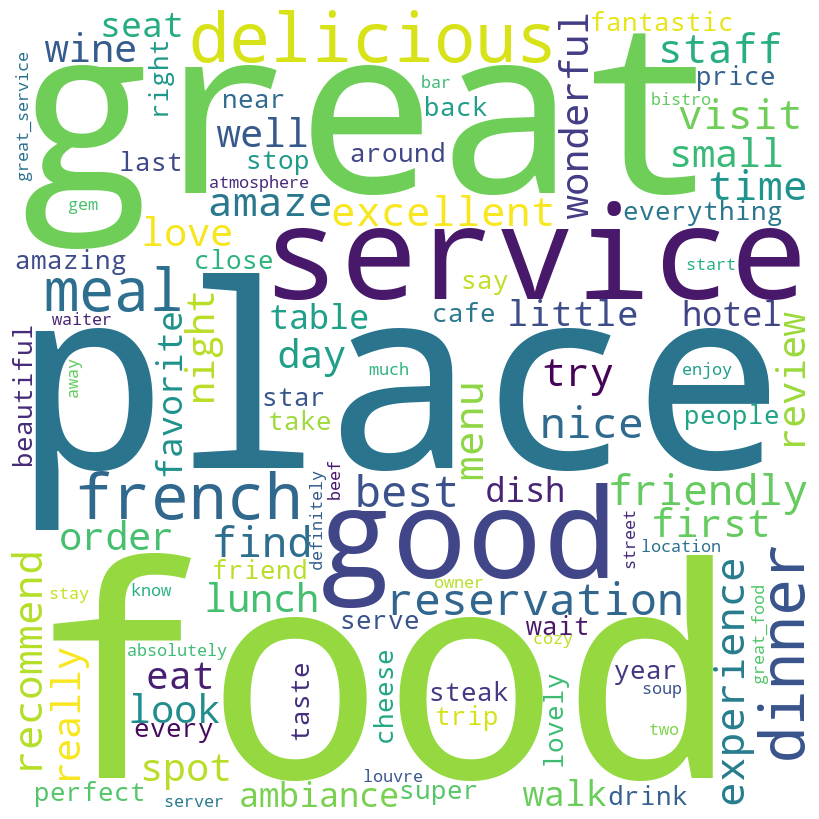

In [114]:
# Création du WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(most_common_words)

# Affichage du WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [115]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize

### LDA TOPIC MODELING

In [146]:
# Préparation des données pour LDA
# Tokenisation des avis prétraités
texts = [word_tokenize(doc) for doc in review_df['preprocessed_text']]

# Création d'un dictionnaire qui mappe chaque mot à un id unique
dictionary = corpora.Dictionary(texts)

# Filtrage des mots extrêmement rares et trop fréquents pour améliorer la qualité des topics
dictionary.filter_extremes(no_below=100, no_above=0.5, keep_n=10000)

# Transformation des documents en vecteurs de sac de mots (Bag of Words)
corpus = [dictionary.doc2bow(text) for text in texts]

# Entraînement du modèle LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=4,
                     random_state=100,
                     update_every=1,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Obtenir les topics
topics = lda_model.print_topics(num_words=4)  # Changer le nombre de mots par topic si nécessaire

for topic in topics:
    print(topic)


(0, '0.375*"service" + 0.266*"delicious" + 0.234*"food" + 0.080*"great"')
(1, '0.536*"good" + 0.252*"reservation" + 0.088*"place" + 0.050*"service"')
(2, '0.362*"food" + 0.346*"place" + 0.142*"french" + 0.073*"meal"')
(3, '0.523*"great" + 0.237*"dinner" + 0.132*"best" + 0.064*"meal"')


In [147]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Activer pyLDAvis dans Jupyter Notebook (pas nécessaire si vous utilisez JupyterLab ou une autre interface)
pyLDAvis.enable_notebook()

# Préparation des données pour pyLDAvis
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Affichage de la visualisation
pyLDAvis.display(lda_display)


In [201]:
# Inférer la distribution des topics pour chaque document
topics_per_document = lda_model.get_document_topics(corpus)

# Créer une liste pour stocker le topic dominant de chaque document
dominant_topics = []
for doc_topics in topics_per_document:
    # Trier les topics par contribution pour ce document et prendre le plus grand
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    dominant_topic = sorted_topics[0][0]  # (topic_num, contribution)
    dominant_topics.append(dominant_topic)

# Créez des titres descriptifs pour chaque topic identifié
topic_titles = {
    0: "Recommended about Food & Service",
    1: "Restaurant with Reservation",
    2: "French Food",
    3: "Restaurant for Dinner"
}

# Associer le titre du topic dominant à chaque document
review_df['Topic_Title'] = [topic_titles[topic] for topic in dominant_topics]

# Afficher les premières lignes du DataFrame avec les nouveaux titres de topic
review_df.head()


,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text,Topic_Title
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positive,base menu present write glow review classiques...,French Food
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positive,place feel little bit tourist trap people din ...,Food with Reservation
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positive,love french onion soup try comptoir la gastron...,French Food
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",negative,daughter son law mom gratin delicious table ex...,Recommended about Food & Service
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positive,tiny eatery along seine leave bank best burger...,Restaurant for Dinner


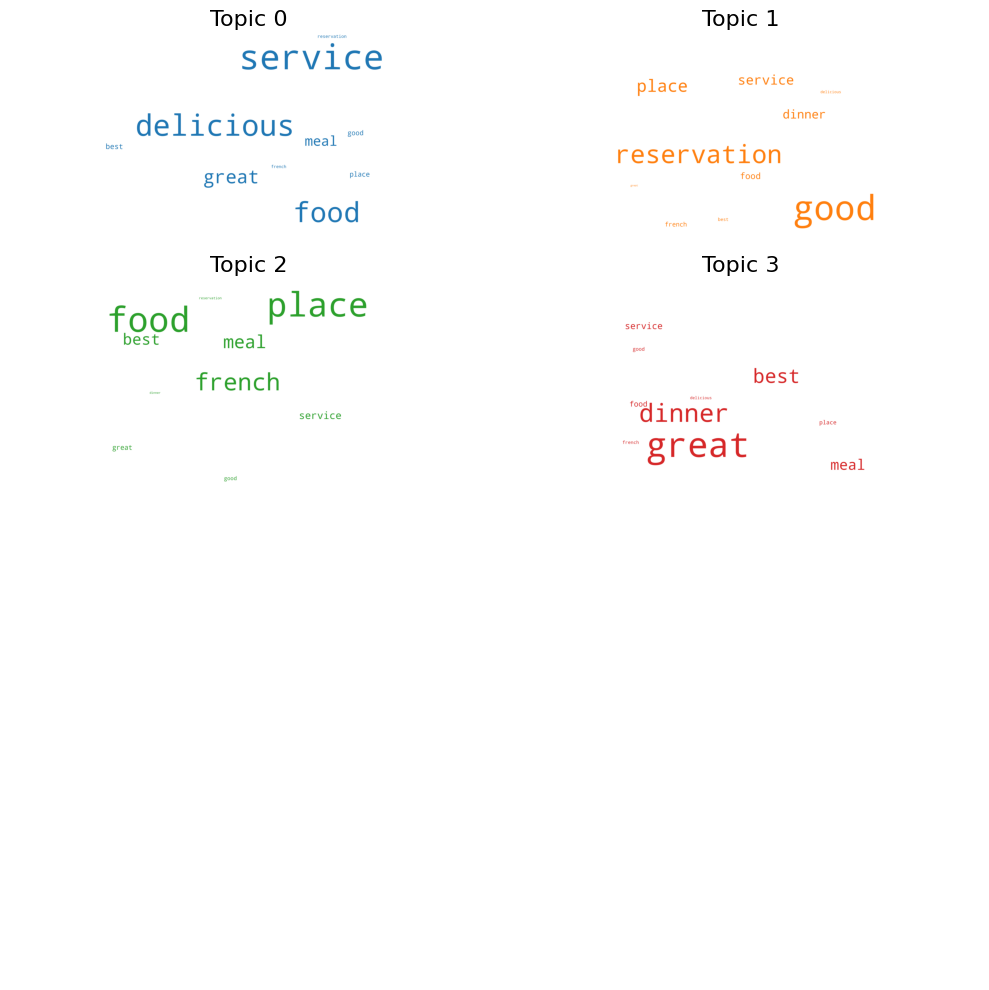

In [245]:
import matplotlib.colors as mcolors

# Génération de couleurs pour les nuages de mots
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i % len(cols)],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=10)

# Nombre de sujets (ajustez selon votre modèle LDA)
num_topics = 4
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud)
        ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
        ax.axis('off')
    else:
        ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [203]:
review_df.to_csv("review_with_topic.csv", sep=";",index = False)

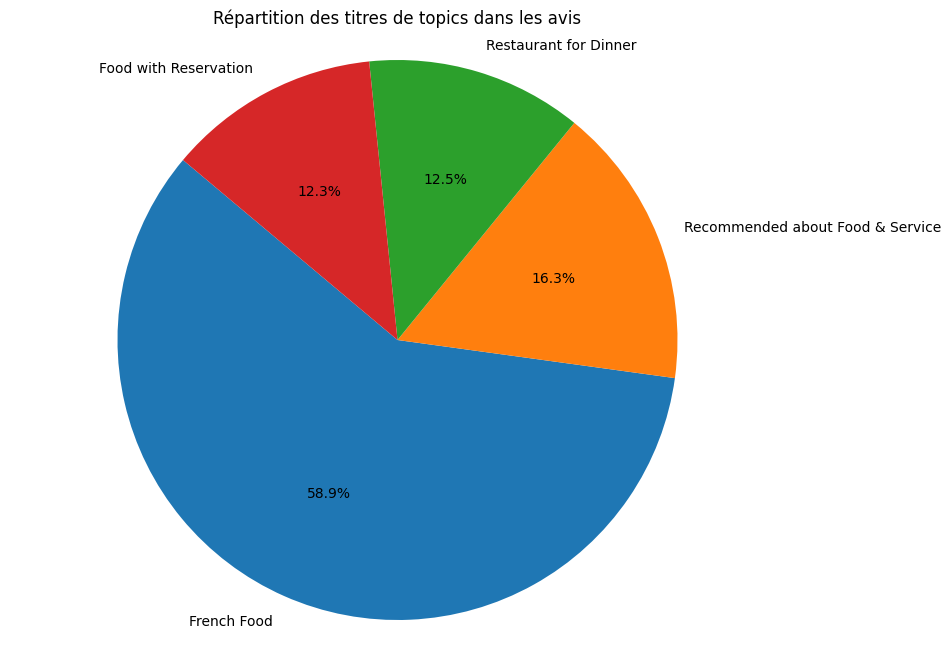

In [204]:
# Compter la fréquence de chaque titre de topic
topic_counts = review_df['Topic_Title'].value_counts()

# Créer un diagramme en camembert
plt.figure(figsize=(10, 8))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Afficher le titre et afficher le graphique
plt.title('Répartition des titres de topics dans les avis')
plt.show()

### Embedding

In [227]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Préparation des données pour Word2Vec (tokenisation a déjà été faite)
texts = [text.split() for text in review_df['preprocessed_text']]

# Entraînement du modèle Word2Vec
#w2v_model = Word2Vec(texts,vector_size=80, window=5, min_count=1, workers=2)
w2v_model = Word2Vec(texts, vector_size=80, window=10, min_count=1, workers=4, epochs=30)

# Enregistrer le modèle pour une utilisation ultérieure
w2v_model.save("word2vec_model.model")

#### Simililarité des mots (en utilisant most_similar et la distance euclidienne)

In [230]:
# Trouver des mots similaires
similar_words = w2v_model.wv.most_similar('great_meal', topn=10) 
print(similar_words)

[('french_cuisine', 0.9973340034484863), ('excellent_service', 0.9972683787345886), ('food_excellent', 0.9972667694091797), ('definitely_recommend', 0.9972148537635803), ('eiffel_tower', 0.997214674949646), ('place_food', 0.9971818923950195), ('foie_gras', 0.997155487537384), ('service_good', 0.9971485733985901), ('ambiance_great', 0.9971393346786499), ('taste_menu', 0.9971340298652649)]


In [233]:
from scipy.spatial import distance

def euclidean_distance(word, model, top_n=10):
    word_vector = model.wv[word]
    all_word_vectors = np.array([model.wv[w] for w in model.wv.index_to_key if w != word])
    
    distances = [distance.euclidean(word_vector, wv) for wv in all_word_vectors]
    nearest_indices = np.argsort(distances)[:top_n]
    
    return [(model.wv.index_to_key[i], distances[i]) for i in nearest_indices]

# Exemple d'utilisation de la distance euclidienne
print(euclidean_distance('chocolate', w2v_model))


[('deal', 0.11645945906639099), ('wine_bar', 0.12198098748922348), ('pastry', 0.13276033103466034), ('noodle', 0.13544191420078278), ('vegetable', 0.13645479083061218), ('kid', 0.13899758458137512), ('cheap', 0.14001767337322235), ('finish', 0.1439582258462906), ('pleasant', 0.14519482851028442), ('caf', 0.1556253731250763)]


#### Affichage

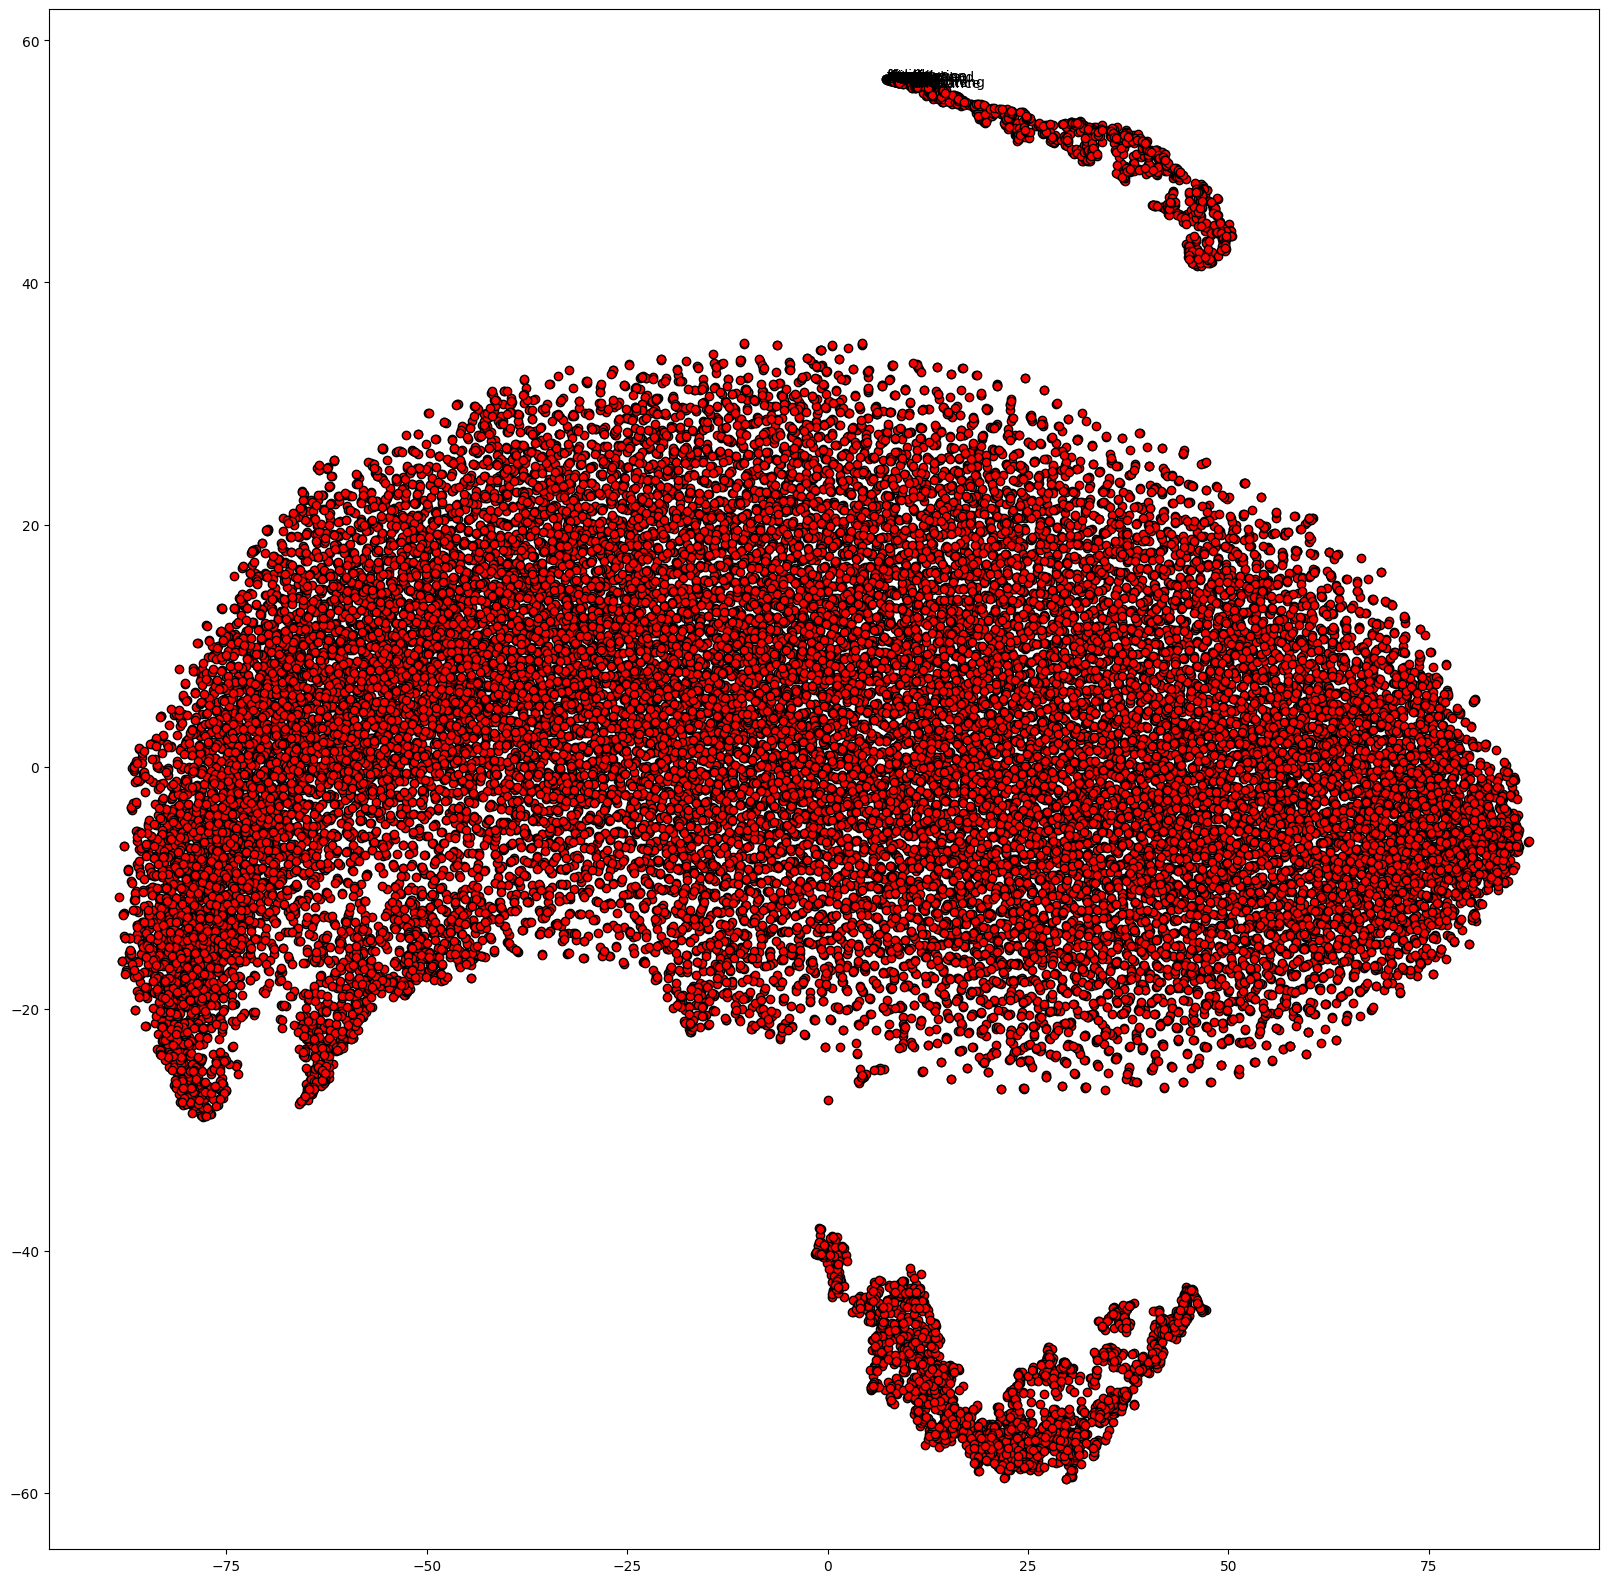

In [234]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Récupérer les vecteurs de mots et les mots correspondants du modèle
words = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[word] for word in words])

# Utiliser t-SNE pour réduire la dimensionnalité
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Visualiser avec Matplotlib
plt.figure(figsize=(20, 20))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], edgecolors='k', c='r')
for i, word in enumerate(words[:50]):
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word)

plt.show()


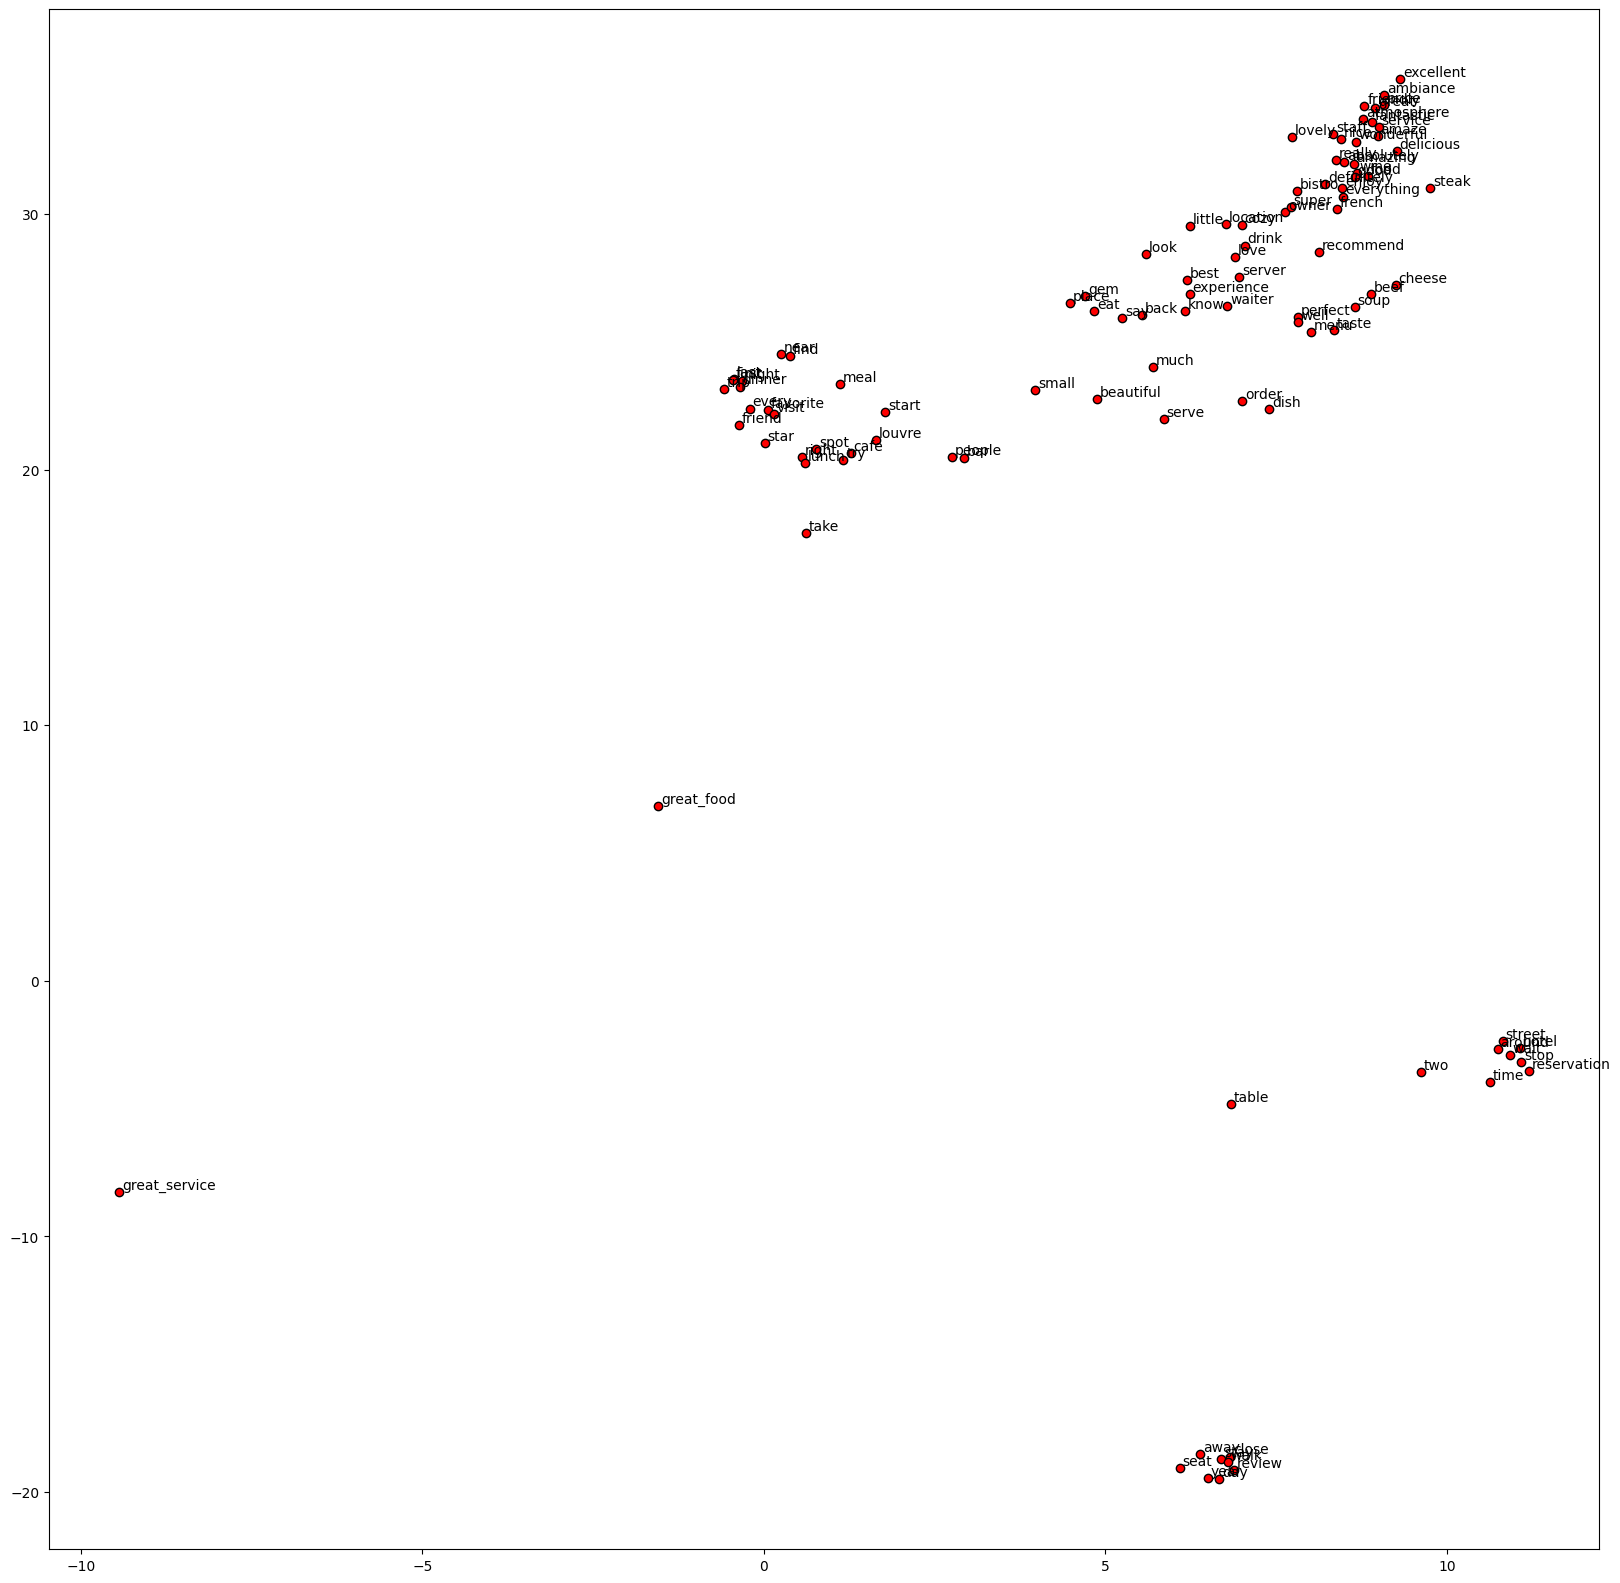

In [255]:
# Cette fois, en utilisant une boucle pour obtenir les fréquences des mots individuels
frequent_words = w2v_model.wv.index_to_key
frequent_counts = [w2v_model.wv.get_vecattr(word, 'count') for word in frequent_words]

# Obtenez les indices des 100 mots les plus fréquents
selected_indices = np.argsort(frequent_counts)[-100:]

# Maintenant, sélectionnez les mots et leurs vecteurs correspondants pour la visualisation
selected_words = [frequent_words[i] for i in selected_indices]
selected_word_vectors = word_vectors_2d[selected_indices]

# Visualiser avec Matplotlib, en affichant uniquement un sous-ensemble de mots
plt.figure(figsize=(20, 20))
plt.scatter(selected_word_vectors[:, 0], selected_word_vectors[:, 1], edgecolors='k', c='r')
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(selected_word_vectors[i, 0], selected_word_vectors[i, 1]), xytext=(2, 2),
                 textcoords='offset points')

plt.show()


In [259]:
import io
import os
import tensorflow as tf
from tensorboard.plugins import projector

# Path pour sauvegarder les fichiers de métadonnées (les étiquettes) et les vecteurs
log_dir = "tensorboard-logs"  
os.makedirs(log_dir, exist_ok=True)

# Exporter les étiquettes
with io.open(os.path.join(log_dir, 'metadata.tsv'), 'w', encoding='utf-8') as file_metadata:
    for word in w2v_model.wv.index_to_key:
        file_metadata.write(word + '\n')

# Paramétrage nécessaire pour TensorBoard
weights = tf.Variable(w2v_model.wv.vectors)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Configurer le projecteur
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)


#### Semantic Research

In [161]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def semantic_search(query, model, texts, top_n=5):
    # Tokeniser et calculer la moyenne des vecteurs de mots pour la requête
    query_tokens = query.split()
    query_vector = average_word_vectors(query_tokens, model, set(model.wv.index_to_key), model.vector_size)
    
    # Calculer la moyenne des vecteurs de mots pour chaque document
    docs_vectors = [average_word_vectors(text.split(), model, set(model.wv.index_to_key), model.vector_size) for text in texts]
    
    # Calculer la similarité cosinus entre la requête et chaque document
    similarities = cosine_similarity([query_vector], docs_vectors).flatten()
    similar_indices = similarities.argsort()[-top_n:][::-1]
    similar_texts = [(texts[i], similarities[i]) for i in similar_indices]
    
    return similar_texts

# Exemple de recherche sémantique
query = "great food and service"
print(semantic_search(query, w2v_model, review_df['preprocessed_text'].tolist()))

[('great tourist experience great food wonderful boat tour night match great food plenty wine opulent level service great_tourist tourist_experience experience_great great_food food_wonderful wonderful_boat boat_tour tour_night night_match match_great great_food food_plenty plenty_wine wine_opulent opulent_level level_service great_tourist_experience tourist_experience_great experience_great_food great_food_wonderful food_wonderful_boat wonderful_boat_tour boat_tour_night tour_night_match night_match_great match_great_food great_food_plenty food_plenty_wine plenty_wine_opulent wine_opulent_level opulent_level_service', 0.789303417372982), ('friendly service excellent french food despite fact touristy area quality service food great friendly_service service_excellent excellent_french french_food food_despite despite_fact fact_touristy touristy_area area_quality quality_service service_food food_great friendly_service_excellent service_excellent_french excellent_french_food french_food_d

### Supervised Learning

Avec modele entrainé

In [265]:
# Convertir les évaluations en labels de sentiment
def convert_rating_to_sentiment(rating):
    if rating < 3:
        return 0  # négatif
    elif rating > 3:
        return 2  # positif
    else:
        return 1  # neutre

# Appliquer la conversion sur la colonne de rating
review_df['sentiment_par_rapport_rating'] = review_df['rating'].apply(convert_rating_to_sentiment)


In [271]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [281]:
# Initialiser et adapter le tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_df['preprocessed_text'])

# Convertir les textes en séquences de nombres
sequences = tokenizer.texts_to_sequences(review_df['preprocessed_text'])

# Padding des séquences pour qu'elles aient toutes la même longueur
MAX_SEQUENCE_LENGTH = 100  # Vous pouvez ajuster cette longueur
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Créer la matrice d'embeddings
embedding_dim = 80  # Doit correspondre à la dimension de vos embeddings Word2Vec
vocab_size = len(tokenizer.word_index) + 1  # Taille du vocabulaire
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv.key_to_index:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = embedding_vector

# Construire le modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Flatten())  # Vous pouvez utiliser des couches LSTM ou Conv1D à la place de Flatten
model.add(Dense(3, activation='softmax'))  # 3 classes pour négatif, neutre et positif

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

labels = review_df['sentiment'].values
model.fit(data, labels, epochs=10, validation_split=0.2)


Epoch 1/10
35/35 [==============================] - 1s 13ms/step - loss: 0.9544 - accuracy: 0.8070 - val_loss: 0.6762 - val_accuracy: 0.8423
Epoch 2/10
35/35 [==============================] - 0s 6ms/step - loss: 0.5730 - accuracy: 0.8321 - val_loss: 0.8167 - val_accuracy: 0.8280
Epoch 3/10
35/35 [==============================] - 0s 6ms/step - loss: 0.5429 - accuracy: 0.8483 - val_loss: 0.7405 - val_accuracy: 0.8566
Epoch 4/10
35/35 [==============================] - 0s 5ms/step - loss: 0.6006 - accuracy: 0.8312 - val_loss: 0.8179 - val_accuracy: 0.8674
Epoch 5/10
35/35 [==============================] - 0s 5ms/step - loss: 0.5408 - accuracy: 0.8537 - val_loss: 0.8161 - val_accuracy: 0.8602
Epoch 6/10
35/35 [==============================] - 0s 5ms/step - loss: 0.5112 - accuracy: 0.8456 - val_loss: 0.7689 - val_accuracy: 0.8530
Epoch 7/10
35/35 [==============================] - 0s 6ms/step - loss: 0.5171 - accuracy: 0.8519 - val_loss: 0.8327 - val_accuracy: 0.7849
Epoch 8/10
35/35 [=

In [282]:
# Pour l'évaluation, vous devez séparer votre ensemble de données en train et test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
 1/31 [..............................] - ETA: 0s - loss: 0.9948 - accuracy: 0.5625

31/31 [==============================] - 0s 7ms/step - loss: 0.5430 - accuracy: 0.8421 - val_loss: 0.7659 - val_accuracy: 0.8517
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5259 - accuracy: 0.8595 - val_loss: 0.8235 - val_accuracy: 0.7943
Epoch 3/10
31/31 [==============================] - 0s 7ms/step - loss: 0.4506 - accuracy: 0.8687 - val_loss: 0.7342 - val_accuracy: 0.8517
Epoch 4/10
31/31 [==============================] - 0s 7ms/step - loss: 0.4333 - accuracy: 0.8677 - val_loss: 0.7753 - val_accuracy: 0.8397
Epoch 5/10
31/31 [==============================] - 0s 8ms/step - loss: 0.4392 - accuracy: 0.8790 - val_loss: 1.0268 - val_accuracy: 0.8541
Epoch 6/10
31/31 [==============================] - 0s 10ms/step - loss: 0.4270 - accuracy: 0.8656 - val_loss: 0.9347 - val_accuracy: 0.6340
Epoch 7/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5116 - accuracy: 0.8533 - val_loss: 0.8635 - val_accuracy: 0.8301
Epoch 8/10
31/31 [============

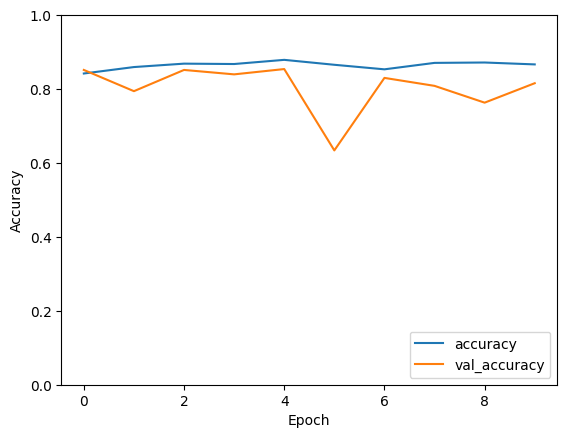

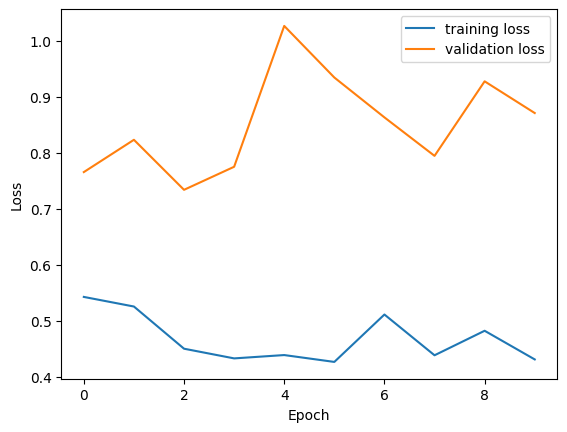

In [284]:
# Tracer la précision
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Tracer la perte
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


9/9 [==============================] - 0s 4ms/step


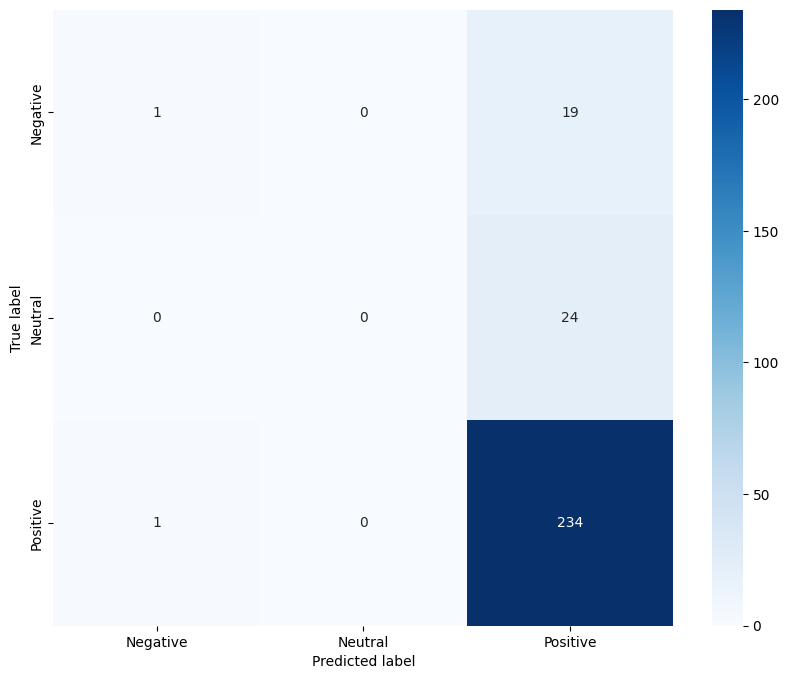

In [275]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prédictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Tracer la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [276]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_classes, target_names=['Negative', 'Neutral', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.50      0.05      0.09        20
     Neutral       0.00      0.00      0.00        24
    Positive       0.84      1.00      0.91       235

    accuracy                           0.84       279
   macro avg       0.45      0.35      0.33       279
weighted avg       0.75      0.84      0.78       279



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Entrainement sur un dataset pris sur Kaggle 